In [1]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE as smote
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import load_svmlight_file
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/abhirajmohan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
corpus_data = pd.read_csv("spam.csv", encoding='latin-1')
print(corpus_data.head())

     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


After printing out the first five rows of our data set, we observe that the last three columns of the data set have unrecognizable values which cannot be used to train our models since they will not provide any important information. We also observe that each message has various stopwords that can be removed. This is believable considering how casual people are with their language when messaging each other. 

In [3]:
corpus_data.shape

(5572, 5)

The data set we wish to use contains 5572 rows which mean 5572 records. These many rows are more than enough to trian our models with. We will explore the class imbalance in our models in later on sections.

In [4]:
corpus_data.columns.tolist()

['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4']

Out of these columns, we care only about v1 and v2. The last three columns we do not care about and will remove.

# Exploratory Data Analysis
After we explore in our data set, there are significant changes we need to make to our data set before we can train our classifier models using this data. First, since we noticed that the last three columns of our data set are useless to training our model, we remove those columns. We do this so that training our models is more optimal run-time wise.

In [5]:
corpus_data = corpus_data.drop(["Unnamed: 2","Unnamed: 3", "Unnamed: 4"], axis=1)
corpus_data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Removing stopwords and punctuations
In Natural Language Processing, a common practice is to remove stopwords and punctuations. Stopwords are common words that are present in almost every text such as "a, this, the", etc. We remove these words from our records since they do not provide models any significant information about each text. Along with that, we need to remove punctuation to be able to construct a TF-IDF matrix out of our data set.

In [6]:
def remove_stopwords(sentence):
    sentence = sentence.split(' ')
    processed_sentence = []
    for word in sentence:
        no_pun = [char for char in word if char not in string.punctuation]
        no_pun = ''.join(no_pun)
        processed_sentence.append(no_pun)
    processed = [word.lower() for word in processed_sentence if word.lower() not in stopwords.words('english')]
    processed = ' '.join(processed)
    return processed
    
stringing = "This is a sample message. Let us see what happens sample meassage"
remove_stopwords(stringing)

'sample message let us see happens sample meassage'

In the code block above, we have defined a function to  remove stop-words and punctuation. Something that we do not do in this section but is extremely common is the practice of stemming text. This is the process of reducing words to their most basic version.

In [7]:
corpus_data["v2"] = corpus_data['v2'].apply(remove_stopwords)

In the above code block, we apply the filter function to remove stopwords and punctuations to reduce our data set to processable string of significant words.

## Creating TF-IDF Matrix
(https://www.elephate.com/blog/what-is-tf-idf/)  
After we have removed all the stopwords and punctuations from each text in the data set, we now have a data set that we can use to build our TF-IDF matrix. We use TF-IDF algorithm to convert our textual data set into a numerical data set.
TF-IDF translates to Term-frequency Inverse-document-frequency which is an algorithm to process text documents. The algorithm takes the word composition of each document and finds the term frequency of each word in the text which the number of times a term occurs in a text. And we calculate the inverse document frequency of a term which is the measure of how much information the term provides which is caluclated as the logarithmic function of the total documents divided by the number of documents that have an occurence of that word. 

In [8]:
vectorizer = TfidfVectorizer()
corpus_tf_idf = vectorizer.fit_transform(corpus_data["v2"])

We call TfidfVectorizer on our data set with an ngram range of (1,1). An ngram range of 1,1 means that our tf-idf matrix will have 1grams as minimum and maximum. In a later iteration of our project, we can vary the ngram range to observe how it change the performance of classifier models.

In [9]:
tf_idf_scores = pd.DataFrame(corpus_tf_idf.todense())
tf_idf_scores.columns = vectorizer.get_feature_names()

In [10]:
tf_idf_scores.shape

(5572, 9376)

In [11]:
# corpus_data_11 = corpus_data
# corpus_data_12 = corpus_data
countr = 0
for i in vectorizer.get_feature_names():
    corpus_data[i] = tf_idf_scores[i]

In [12]:
corpus_data.head()

,v1,v2,008704050406,0089my,0121,01223585236,01223585334,0125698789,02,020603,...,ìï,ìïll,ûthanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell
0,ham,go jurong point crazy available bugis n great ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ham,ok lar joking wif u oni,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,spam,free entry 2 wkly comp win fa cup final tkts 2...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ham,u dun say early hor u c already say,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ham,nah dont think goes usf lives around though,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


After converting our matrix to a Tf-idf matrix, we see that our matrix is extremely sparse because of the high occurence of 0 values. This is characteristic of a Tf-idf matrix since some terms out of the whole corpus will never be part of some texts.

After converting our text data set into a TF-IDF, we can check for null values as a sanity check to make sure we did not lose any information.

In [13]:
df_is_na = corpus_data.isna()
no_missing_values = 0
for index, row in df_is_na.iterrows():
    if(row[1]):
        no_missing_values += 1
print("Number of missing values =",no_missing_values)

Number of missing values = 0


The number fo null values in our tf-idf matrix our 0

In [14]:
corpus_data = corpus_data.drop("v2", axis=1)
corpus_data.head()

,v1,008704050406,0089my,0121,01223585236,01223585334,0125698789,02,020603,0207,...,ìï,ìïll,ûthanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell
0,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,spam,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ham,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
corpus_data.shape

(5572, 9377)

as we can see, our data set maintains the number of rows. Thus, we retain all the information throughout all the pre-processing.

We now proceed to split our data into training and test data sets in the ratio of 8 is to 2.

In [21]:
corpus = corpus_data.drop("v1", axis=1)
training_corpus, test_corpus, training_label, test_label = train_test_split(corpus, corpus_data["v1"], test_size=0.2)

In [23]:
test_corpus.shape

(1115, 9376)

## Exploring Class Imbalance
For our purposes, we wish to train our models to the best capacity. Thus, we explore our data sets to see if there is a class imbalance. Unchecked class imbalance causes a bias towards the majority class when we run our models to classify and predict test sets.

To explore class imbalance, we visualize the two classes in our data set.

Text(0,0.5,'number of records')

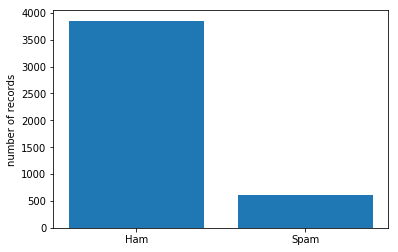

In [24]:
count_of_ham = training_corpus[training_label == "ham"].shape[0]
count_of_spam = training_corpus[training_label == "spam"].shape[0]
plt.bar(["Ham", "Spam"], height=[count_of_ham, count_of_spam])
plt.ylabel("number of records")

We observe that there is a clear difference in the number of records that are spam and that are ham in our data set. To deal with this problem, we will run SMOTE on our data set. Synthetic Minority Over-Sampling Technique or SMOTE simulatneously overs-samples the minority class and under-samples the majority class (https://jair.org/index.php/jair/article/view/10302). We run this algorithm on our training data set to obtain the same class count for both the classes.

In [25]:
sml = smote(random_state=12)
X, y = sml.fit_sample(training_corpus, training_label)

Text(0,0.5,'Number of records')

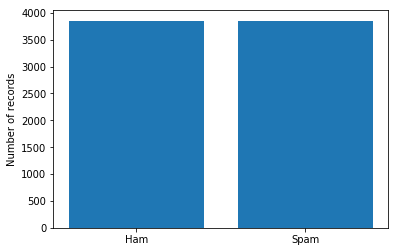

In [26]:
X = pd.DataFrame(X)
X.columns = training_corpus.columns
y = pd.DataFrame(y)
count_of_ham = y[y[0] == "ham"].shape[0]
count_of_spam = y[y[0] == "spam"].shape[0]
plt.bar(["Ham", "Spam"], height=[count_of_ham, count_of_spam])
plt.ylabel("Number of records")

After running SMOTE on our data-set, we can observe that the count of ham in our data set and count of spam is the same. We will retain our unbalanced data as well, however, to observe how balancing classes affects the performance of our classifier models.

In [27]:
training_corpus.head()

,008704050406,0089my,0121,01223585236,01223585334,0125698789,02,020603,0207,02070836089,...,ìï,ìïll,ûthanks,ûªm,ûªt,ûªve,ûï,ûïharry,ûò,ûówell
4359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
79,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


At then end of this section, our data set is extremely high dimensional. In a next iteration of our project, we wish to explore PCA to dimensionally reduce the data set.

# Models
After we pre-process our data and split it into our test and training set, we can now train our models. We, for our purposes, analyse three different models - Logistic Regression, Naïve Bayes and K-Nearest Neighbor. Two out of these three models are parametric models and one out of these three models is non-parametric. By selecting both kinds of models, we are able to analyze which of these kinds also works the best for text classification.
## Logistic Regression
(http://cs229.stanford.edu/notes/cs229-notes1.pdf)  
Logistic regression is a classification model that fits a sigmoid function on a linear regression model to obtain the probability of a sample belonging to a class and classifies test samples in this manner. First, we train our logistic regression model on the unbalanced data set and then we train on our SMOTE'd data set and test both on the test data set.

In [28]:
lr = LogisticRegression()
lr.fit(training_corpus, training_label)
labels = lr.predict(test_corpus)

### SMOTE

In [29]:
lr = LogisticRegression()
lr.fit(X, y.values.ravel())
labels_sm = lr.predict(test_corpus)

## Gaussian Naïve Bayes
Gausian Naïve Bayes is a parametric classifier model. It takes the samples and predicts continuous multidimensional Gaussian distributions for each class. It then predicts the class of a test sample based on the conditional probability of the sample belonging to a distribution. It utilizes Bayes theorem to classify data samples.

In [30]:
nb = GaussianNB()
nb.fit(training_corpus, training_label)
labels2 = nb.predict(test_corpus)

### SMOTE

In [31]:
nb = GaussianNB()
nb.fit(X, y.values.ravel())
labels2_sm = nb.predict(test_corpus)

We train our Gaussian Naïve Bayes model on our SMOTE'd data for further analysis.

## K Nearest Neighbor
(https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html)  

Out of all three classifier mdoels that we are using to build our spam classifier, K-Nearest Neighbor is the only non-parametric classifier. What this means is that KNN does not derive any parameters from the data set to classify samples unlike Logistic Regression or Naïve Bayes. 
K-Nearest neighbor algorithm works by classifying a test sample the same classes as its nearest K-neighbors. To analyze how well the algorithm works for our spam classifier, we will be using four distance measures:
- Chebyshev distance: max(|x - y|)
- Manhattan distance: sum(|x - y|)
- Euclidean distance: sqrt(sum((x - y)^2))  

These distance measures are used to find the K-nearest neighbors. This can change our final metrics since we are varying the closest neighbors of a sample. We set the K-value to 5 as a default for all models. In a seperate experiment, we would like to experiment with different K values as well.

In [32]:
knn_cheb = KNeighborsClassifier(n_neighbors = 5, metric='chebyshev')
knn_man = KNeighborsClassifier(n_neighbors = 5, metric='manhattan')
knn_euc = KNeighborsClassifier(n_neighbors = 5, metric='euclidean')
knn_cheb.fit(training_corpus, training_label)
knn_man.fit(training_corpus, training_label)
knn_euc.fit(training_corpus, training_label)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [33]:
labels3_man = knn_man.predict(test_corpus)
labels3_cheb = knn_cheb.predict(test_corpus)
labels3_euc = knn_euc.predict(test_corpus)

In the two code blocks above, we fit our models on our unbalanced training data set and predict values for our test data sets.

### SMOTE
Now, we will train our models on our balanced training data set and predict value on our test data set.

In [34]:
knn_cheb.fit(X, y.values.ravel())
knn_man.fit(X, y.values.ravel())
knn_euc.fit(X, y.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [35]:
labels3_man_sm = knn_man.predict(test_corpus)
labels3_cheb_sm = knn_cheb.predict(test_corpus)
labels3_euc_sm = knn_euc.predict(test_corpus)

After we have all of our different classification models trained, we move onto our analysis section to analyze all of our different metrics.

# Analysis
This section is for analyzing our metrics for the different models and compare them. For each of our model,we obtain the confusion matrix and observe the overall accuracy of our test data set and the precision, recall score for our two classes which are ham and spam. 
For our spam classifier, we care more about our precision score and recall score for ham class. For a spam classifier, it is imperative that we do not put ham messages that are not spam into the spam folder or completely block them. The recall score measures how many of our non-spam messages are classified correctly and precision measures how many of our non-spam messages are actually classified as non-spam. We will be measuring the precision and recall of our spam class as well to compare.

## Logistic Resgression
First, we observe metrics of our logistic regression classifier model.

In [36]:
metrics.confusion_matrix(test_label, labels)

array([[971,   0],
       [ 51,  93]])

In [37]:
print(metrics.classification_report(test_label, labels, digits=4))
print("Accuracy is = ", metrics.accuracy_score(test_label, labels))

             precision    recall  f1-score   support

        ham     0.9501    1.0000    0.9744       971
       spam     1.0000    0.6458    0.7848       144

avg / total     0.9565    0.9543    0.9499      1115

Accuracy is =  0.9542600896860987


What we observe from the confusion metrics first is that there are 1115 records in our test class, 944 of which are ham and 171 of which are spam. We observe that our accuracy is ~ 0.95 which seems optimal. A precision socre of 0.94 for ham indicated that 94 percent of predicted ham messges are ham and the remaining 6 percent are spam. Thus, when we implement our spam filter, only 6 percent of our predicted non spam messages would be faulty. A recall score of 0.99 indicated that almost all non-spam messages are unblocked which is optimal to maintain a minimal loss of information. The low recall score for spam class can be attributed to the fact that we trained our model on an unbalaned training set which will cause a level of inability in our model to classify the minority class - "spam". 

### SMOTE

In [38]:
metrics.confusion_matrix(test_label, labels_sm)

array([[961,  10],
       [ 18, 126]])

In [39]:
print(metrics.classification_report(test_label, labels_sm, digits=4))
print("Accuracy is = ", metrics.accuracy_score(test_label, labels_sm))

             precision    recall  f1-score   support

        ham     0.9816    0.9897    0.9856       971
       spam     0.9265    0.8750    0.9000       144

avg / total     0.9745    0.9749    0.9746      1115

Accuracy is =  0.9748878923766816


As we compare our balanced model against our unbalanced model, we see that there is a 0.03 increase in accuracy which suggests that balancing the training data set improved our spam filter. By oversampling the minority class, we improve weights for each term in the set of texts. There is a strong increase of 0.25 in our recall score for spam class. This indicates that a significant portion of spams are correctly recognized by our spam filter. 
Because logistic regression is a paramteric classification model, it derives a set of parameters (weights for each dimension or term) that it uses to classify texts. As we balance our training data set, the model gets a better estimate for all the terms that belong to the spam class and that causes an increase in recall score for spam class. 

## Gaussian Naïve Bayes

In [40]:
metrics.confusion_matrix(test_label, labels2)

array([[856, 115],
       [ 11, 133]])

In [41]:
print(metrics.classification_report(test_label, labels2, digits=4))
print("Accuracy is = ", metrics.accuracy_score(test_label, labels2))

             precision    recall  f1-score   support

        ham     0.9873    0.8816    0.9314       971
       spam     0.5363    0.9236    0.6786       144

avg / total     0.9291    0.8870    0.8988      1115

Accuracy is =  0.8869955156950673


Right away, we observe a lower accuracy score and a lower recall score for ham class. This indicates that a higher portion of our non-spam messages are blocked by our filter and are classified as false negatives. This is not optimal for a spam filter as blocking non spam messages is a significant loss. This is also reflected in the low precision socre for spam class as almost half of the messages that are blocked are non-spam. 
For pure conjecture, we can suggest that this happens because of we are using a Gaussian distribution to classify. If we use a multinomial or bernoulli distrbution then we might see different results which is reflected in other works done on this (http://www2.aueb.gr/users/ion/docs/ceas2006_paper.pdf). In a multinomial event model, each term occurence is modelled as a discreet event instead of predicting a continuous distribution which makes a better classifier model for our spam classifier. In the nexxt iteration, this would be something we would wish to explore further.

### SMOTE

In [42]:
metrics.confusion_matrix(test_label, labels2_sm)

array([[856, 115],
       [ 11, 133]])

In [43]:
print(metrics.classification_report(test_label, labels2_sm, digits=4))
print("Accuracy is = ", metrics.accuracy_score(test_label, labels2_sm))

             precision    recall  f1-score   support

        ham     0.9873    0.8816    0.9314       971
       spam     0.5363    0.9236    0.6786       144

avg / total     0.9291    0.8870    0.8988      1115

Accuracy is =  0.8869955156950673


We do not observe a difference in our metrics after we balance classes which indicates changing the sample size for the classes does not chance the parameters of the guassian distribution. 
Like we said in the last section, modeling a different Naïve Bayes model will possibly improve our spam filter model. In a future iteration of this project, we would like to explore that.

## K-Nearest Neighbor
After observing both of the parametric classifier models, we now observe K-Nearest neighbor and metrics outputted from that. First, we analyze KNN model on our un-balanced training data set. Since KNN is a non-parametric model, we can hypothesize that we will see a high uprise in metrics after we test on our balanced training model. 

#### Chebyshev distance
Chebyshev distance is measured by finding the maximum distance between two terms out of all the terms common between the two texts. 

In [44]:
metrics.confusion_matrix(test_label, labels3_cheb)

array([[933,  38],
       [ 83,  61]])

In [45]:
print(metrics.classification_report(test_label, labels3_cheb, digits=4))
print("Accuracy is = ", metrics.accuracy_score(test_label, labels3_cheb))

             precision    recall  f1-score   support

        ham     0.9183    0.9609    0.9391       971
       spam     0.6162    0.4236    0.5021       144

avg / total     0.8793    0.8915    0.8827      1115

Accuracy is =  0.8914798206278027


Right away, we observe a lower accuracy that both of our parametric models which is a clear indication of how having an unbalanced data set impacts our model. A low precision and recall value for the spam class is because the training set does not have as many spam samples. We still obtain a high recall and precision for ham messages. Out of our unblocked messages, 89 percent are ham messages and 88 percent of our ham messages are relayed. However, more than 50 percent of our spam messages are misclassified. 

#### Manhattan distance
Manhattan distance is taken by summing the distance between all of the terms between the two documents. 

In [46]:
metrics.confusion_matrix(test_label, labels3_man)

array([[971,   0],
       [103,  41]])

In [47]:
print(metrics.classification_report(test_label, labels3_man, digits=4))
print("Accuracy is = ", metrics.accuracy_score(test_label, labels3_man))

             precision    recall  f1-score   support

        ham     0.9041    1.0000    0.9496       971
       spam     1.0000    0.2847    0.4432       144

avg / total     0.9165    0.9076    0.8842      1115

Accuracy is =  0.9076233183856502


We observe a better accuracy when we measure similarity through Manhattan distance but we also observe an extremely low recall value for recall for spam class. This is because 125 of spam messages are not caught by the spam filter and are misclassified. We see a 100 percent precision for spams and recall for hams which indicates that none of actual ham messages are misclassified as spam.

#### Euclidean distance
Euclidean distance measure is the same as Manhattan except distance is calculated in a 2-norm space.

In [48]:
metrics.confusion_matrix(test_label, labels3_euc)

array([[971,   0],
       [104,  40]])

In [49]:
print(metrics.classification_report(test_label, labels3_euc, digits=4))
print("Accuracy is = ", metrics.accuracy_score(test_label, labels3_euc))

             precision    recall  f1-score   support

        ham     0.9033    1.0000    0.9492       971
       spam     1.0000    0.2778    0.4348       144

avg / total     0.9158    0.9067    0.8827      1115

Accuracy is =  0.9067264573991032


We see metrics almost the same as Manhattan which is an indication of the similarity between the ways distance is calculated between two different samples.

Throughout all of our different KNN models, we see a consistent decrease in the precision and recall values for spam class. This is a direct result of training our models on an unbalanced data set. Because we have a major class and a minor class in our training data set, our model has a strong bias towards the majority class. Thus, more than half of spam samples are misclassified. 

### SMOTE
We also trained our KNN models on balanced training models and we can analyze if our hypothesis was correct and we see an increase in the accuracy and precision and recall from the test results. 

#### Chebyshev distance

In [50]:
metrics.confusion_matrix(test_label, labels3_cheb_sm)

array([[901,  70],
       [ 69,  75]])

In [51]:
print(metrics.classification_report(test_label, labels3_cheb_sm, digits=4))
print("Accuracy is = ", metrics.accuracy_score(test_label, labels3_cheb_sm))

             precision    recall  f1-score   support

        ham     0.9289    0.9279    0.9284       971
       spam     0.5172    0.5208    0.5190       144

avg / total     0.8757    0.8753    0.8755      1115

Accuracy is =  0.8753363228699551


We see an increase in the recall scores for our model here as well but not as large as for Manhattan distance which might be a result of the fact that Chebyshev distance measures the maximum distance between two term tf-idf values which does not account for other words. This indicates that Chebyshev might be a poor distance measure for, measuring similarity between texts regardless. We still observe an increase in the accuracy score of the model.

#### Manhattan distance

In [52]:
metrics.confusion_matrix(test_label, labels3_man_sm)

array([[971,   0],
       [ 52,  92]])

In [53]:
print(metrics.classification_report(test_label, labels3_man_sm, digits=4))
print("Accuracy is = ", metrics.accuracy_score(test_label, labels3_man_sm))

             precision    recall  f1-score   support

        ham     0.9492    1.0000    0.9739       971
       spam     1.0000    0.6389    0.7797       144

avg / total     0.9557    0.9534    0.9488      1115

Accuracy is =  0.9533632286995516


We see a significant increase of in the recall value for spam class and the precision value for ham class. This indicated that after we balanced our training data, our model now has a stronger capability to distniguish which samples are spam.

#### Euclidean distance

In [54]:
metrics.confusion_matrix(test_label, labels3_euc_sm)

array([[970,   1],
       [ 46,  98]])

In [55]:
print(metrics.classification_report(test_label, labels3_euc_sm, digits=4))
print("Accuracy is = ", metrics.accuracy_score(test_label, labels3_euc_sm))

             precision    recall  f1-score   support

        ham     0.9547    0.9990    0.9763       971
       spam     0.9899    0.6806    0.8066       144

avg / total     0.9593    0.9578    0.9544      1115

Accuracy is =  0.957847533632287


With the significant increase in the accuracy score, we also observe an increase in the recall value for spam. A good hundred percent of our ham messages make it through the filter and 94 percent of our ham messages are true ham messages. That is acceptable for our model. However, 33 percent of spam messages make it past the filter and are misclassified as ham messages.

From the metrics that we obtained from all of our models, we see that accuracy score increases by a lot for KNN when the data is balanced. 

## Comparison of metrics

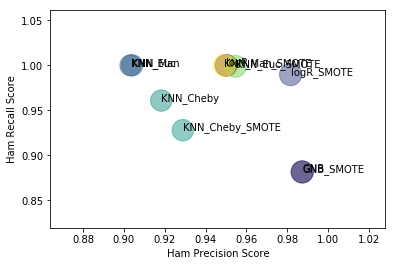

In [56]:
data_x = [metrics.precision_score(test_label, labels, pos_label="ham"),
         metrics.precision_score(test_label, labels_sm, pos_label="ham"),
         metrics.precision_score(test_label, labels2, pos_label="ham"),
         metrics.precision_score(test_label, labels2_sm, pos_label="ham"),
         metrics.precision_score(test_label, labels3_cheb, pos_label="ham"),
         metrics.precision_score(test_label, labels3_cheb_sm, pos_label="ham"),
         metrics.precision_score(test_label, labels3_euc, pos_label="ham"),
         metrics.precision_score(test_label, labels3_euc_sm, pos_label="ham"),
         metrics.precision_score(test_label, labels3_man, pos_label="ham"),
         metrics.precision_score(test_label, labels3_man_sm, pos_label="ham")]

data_y = [metrics.recall_score(test_label, labels, pos_label="ham"),
         metrics.recall_score(test_label, labels_sm, pos_label="ham"),
         metrics.recall_score(test_label, labels2, pos_label="ham"),
         metrics.recall_score(test_label, labels2_sm, pos_label="ham"),
         metrics.recall_score(test_label, labels3_cheb, pos_label="ham"),
         metrics.recall_score(test_label, labels3_cheb_sm, pos_label="ham"),
         metrics.recall_score(test_label, labels3_euc, pos_label="ham"),
         metrics.recall_score(test_label, labels3_euc_sm, pos_label="ham"),
         metrics.recall_score(test_label, labels3_man, pos_label="ham"),
         metrics.recall_score(test_label, labels3_man_sm, pos_label="ham")]

colors = np.random.rand(10)
n = [1,2,3,4,5,6,7,8,9,0]
fig, ax = plt.subplots()
area = [500 * value for value in data_x]
ax.scatter(data_x, data_y, c=colors, s = area ,alpha=0.5)
ax.set_xlabel("Ham Precision Score")
ax.set_ylabel("Ham Recall Score")
label = ["logR", "logR_SMOTE", "GNB", "GNB_SMOTE",
          "KNN_Cheby", "KNN_Cheby_SMOTE", "KNN_Euc", "KNN_Euc_SMOTE", "KNN_Man", "KNN_Man_SMOTE"]
c = 0
for i in label:
    ax.annotate(i, (data_x[c], data_y[c]))
    c = c + 1

As we plot the precision score and recall score for all of our models, we see that logistic regression performs the best since it has the best combination of the two after we train it on our SMOTE data. All the KNN models except for those calculated with the Chebyshev distance have a 100 percent recall when we train them on SMOTE data.

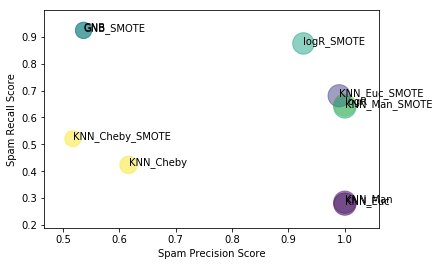

In [57]:
data_x = [metrics.precision_score(test_label, labels, pos_label="spam"),
         metrics.precision_score(test_label, labels_sm, pos_label="spam"),
         metrics.precision_score(test_label, labels2, pos_label="spam"),
         metrics.precision_score(test_label, labels2_sm, pos_label="spam"),
         metrics.precision_score(test_label, labels3_cheb, pos_label="spam"),
         metrics.precision_score(test_label, labels3_cheb_sm, pos_label="spam"),
         metrics.precision_score(test_label, labels3_euc, pos_label="spam"),
         metrics.precision_score(test_label, labels3_euc_sm, pos_label="spam"),
         metrics.precision_score(test_label, labels3_man, pos_label="spam"),
         metrics.precision_score(test_label, labels3_man_sm, pos_label="spam")]

data_y = [metrics.recall_score(test_label, labels, pos_label="spam"),
         metrics.recall_score(test_label, labels_sm, pos_label="spam"),
         metrics.recall_score(test_label, labels2, pos_label="spam"),
         metrics.recall_score(test_label, labels2_sm, pos_label="spam"),
         metrics.recall_score(test_label, labels3_cheb, pos_label="spam"),
         metrics.recall_score(test_label, labels3_cheb_sm, pos_label="spam"),
         metrics.recall_score(test_label, labels3_euc, pos_label="spam"),
         metrics.recall_score(test_label, labels3_euc_sm, pos_label="spam"),
         metrics.recall_score(test_label, labels3_man, pos_label="spam"),
         metrics.recall_score(test_label, labels3_man_sm, pos_label="spam")]

colors = np.random.rand(10)
n = [1,2,3,4,5,6,7,8,9,0]
fig, ax = plt.subplots()
area = [500 * value for value in data_x]
ax.scatter(data_x, data_y, c=colors, s = area ,alpha=0.5)
ax.set_xlabel("Spam Precision Score")
ax.set_ylabel("Spam Recall Score")
label = ["logR", "logR_SMOTE", "GNB", "GNB_SMOTE",
          "KNN_Cheby", "KNN_Cheby_SMOTE", "KNN_Euc", "KNN_Euc_SMOTE", "KNN_Man", "KNN_Man_SMOTE"]
c = 0
for i in label:
    ax.annotate(i, (data_x[c], data_y[c]))
    c = c + 1

From our plots for precision and recall for spam class, we observe that Logistic Regression perfomrs better than all models if we think about it in terms of a combination of the two. The logistic regression model that is trained on an unbalanced data set and majortiy of the KNN models bar the Chebyshev distance KNN model all have a good spam precision score but have a low spam recall score. Similarly, Gaussian Naïve Bayes models and KNN models with a Chebyshev distance mesaure has a higher spam recall score but a lower spam recall score.

# Conclusion

By running our analysis, we observe the following:
- TF-IDF matrix is a sparse matrix
- Logisitc regression model performs optimally with an unbalanced training data set but performs better with a balanced training data set. We obtained a high positive precision and recall score. 
- Gaussian Naïve Bayes is not the most optimal Naïve Bayes algorithm to use for building a spam filter because it derives a continuous Gaussian distribution instead of a discreet distribution like Multinomial or Bernoulli. We observe a lowe rpositive recall score which is not optimal.
- KNN, being a non-parametric model performs better with a more balanced training data set and Chebyshev distance is not optimal to use as a distance measure for our K-Nearest NEighbor model.

## Future Iteration
For furture iterations, we would like to explore the following analyses:
- Explore stemming our messages and see how that affects performance of models
- Reduce the dimensionality of the TF-IDF matrix by implementing dimensionality reduction techniques such as PCA to see if noise is reduced
- Explore other N-gram ranges for our TF-IDf matrix
- Explore Multinomial or Bernoulli Naïve Bayes models
- Explore different K-values for KNN across different distance measures.

<h3> References: </h3>
1. To train our models, we use a spam SMS collection data set obtained from https://www.kaggle.com/uciml/sms-spam-collection-dataset/home, https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
2. For documentation of distance metrics https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html
3. Metrics explanation: https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall
4. Naïve Bayes analysis: http://www2.aueb.gr/users/ion/docs/ceas2006_paper.pdf
5. Information about TF-IDF: https://www.elephate.com/blog/what-is-tf-idf/
6. Information about Logistic Regression: http://cs229.stanford.edu/notes/cs229-notes1.pdf
7. Used as coding reference: http://nbviewer.jupyter.org/github/andressotov/News-Categorization-MNB/blob/master/News_Categorization_MNB%2010-oct-2017.ipynb
8. Used for refering to usages: https://www.kaggle.com/madpiano/spam-sms-classification-using-knn